In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import quadrature
from scipy.optimize import fmin
np.seterr("warn")

def central_finite(x):
    v = np.zeros(len(x))
    for i in range(0, len(x)):
        if i == 0:
            v[i] = (x[i + 1] - x[i]) / 0.001
        elif i == len(x) - 1:
            v[i] = (x[i] - x[i - 1]) / 0.001
        else:
            v[i] = (x[i + 1] - x[i - 1]) / 0.002
    return v

data = pd.read_csv("data/data_laminate.csv", dtype={"beta": object})
data = data.round(decimals=10)
betas = pd.unique(data['beta'])
dfs = []
linear_fit_vs = []
for beta in betas:

    df = data.loc[data['beta'] == beta]
    dfs.append(df)
    t = df["t"].values
    x_bot = df["x_bot"].values
    x_top = df["x_top"].values
    x_mid = df["x_mid"].values
    alpha_bot = df["alpha_bot"].values
    alpha_mid = df["alpha_mid"].values
    alpha_top = df["alpha_top"].values

    vel_mask = np.where((t > 10) & (t < 23))
    v, b = np.polyfit(t[vel_mask], x_mid[vel_mask], deg=1)
    linear_fit_vs.append(np.round(v*1000, 3))

A_0 = np.load("data/A_0.npy")
A_45 = np.load("data/A_45.npy")
A_90 = np.load("data/A_90.npy")
A_15 = np.load("data/A_15.npy")
A_30 = np.load("data/A_30.npy")
A_60 = np.load("data/A_60.npy")
A_75 = np.load("data/A_75.npy")

A_ortho_45 = np.load("data/A_45_alt.npy")
A_ortho_60 = np.load("data/A_60_alt.npy")
A_15_alt = np.load("data/A_15_alt.npy")
A_30_alt = np.load("data/A_30_alt.npy")
A_75_alt = np.load("data/A_75_alt.npy")

kf1 = 6.83
kf2 = 2.7
Ar = 8.55e15  # PTD Pre-exponential factor (s^-1) --> why?
Hr = 350000  # Heat of reaction (Joules per gram)
phi = 0.3  # Fiber volume fraction
kr = 0.15  # Thermal conductance of DCPD-2
Er = 110750.0  # DCPD-2 activation energy (Joules per mol) for PTD model
rhor = 980  # density of DCPD-2 (kg / m^3)
rhof = 1800.0  # Density of fibers (kg / m^3)
R = 8.314  # Ideal gas constant (8.314J/K⋅mol)
ac = 0.41  # Cutoff of reaction dominated by reaction to diffuse regimes
a0 = 0.1  # Initial degree of cure
m = 0.77  # reaction order
n = 1.72
Cpf = 1129.0  # Carbon fiber specific heat (Joules per kg*K)
Ca = 14.48  # unitless --> controls the rate at which the reaction becomes diffusion dominated
Cpr = 1600.0  # DCPD-2 Specific Heat (Joules per kg*K)
rho_cp_bar = Cpr * rhor * (1 - phi) + Cpf * rhof * phi
T0 = 20 + 273.15  # Initial temp

# thermal cond. parallel to fibers (fiber frame)
k_1_fun = lambda p: kr * (1 - p) + kf1 * p

# thermal cond. perpendicular to fibers (fiber frame)
k_2_fun = lambda p: kr * (kf2 * (1 + p) + kr * (1 - p)) / (kf2 * (1 - p) + kr * (1 + p))

kf_parallel = k_1_fun(phi)
kf_perp = k_2_fun(phi)

print(f"K parallel to fibers = {kf_parallel}, K perpendicular to fibers = {kf_perp}\n")


# Prout-Tompskin with diffusion cure kinetic model [g(alpha)] integrand
def pi_integrand(y, m, n, Ca, ac, eps):
    first = y / ((y + eps) ** n * (1 - eps - y) ** m)
    second = 1 + np.exp(Ca * (1 - eps - ac - y))

    return first * second


# Reaction temperature estimate (maximizes temp gradient at front)
def T_hat(eps, T0, phi, a0, rhor, Hr, rho_cp_bar):
    return T0 + ((1 - phi) * (1 - a0 - eps) * rhor * Hr) / rho_cp_bar


# Front velocity
def V_front(T, pi, Ar, k, R, Er, rhor, Hr, phi):
    numerator = Ar * k * R * T**2 * np.exp(-Er / (R * T))
    denom = rhor * Hr * (1 - phi) * Er * pi

    return (numerator / denom) ** 0.5


pi = lambda eps: quadrature(
    pi_integrand, 0, 1 - eps - a0, args=(m, n, Ca, ac, eps), maxiter=int(1e4)
)[0]

T_est = lambda eps: T_hat(eps, T0, phi, a0, rhor, Hr, rho_cp_bar)

Vs = []
Vs_corrected = []
As = [A_0, A_45, A_90, A_ortho_45, A_ortho_60, A_15, A_30, A_60, A_75, A_15_alt, A_30_alt, A_75_alt]
print(betas)
for i, A in enumerate(As):
    # print(betas[i])
    # print(betas[-1] not in ['15', '30', '45', '60', '75'])
    # print(i == len(As) - 1)
    if betas[i] not in ['15', '30', '45', '60', '75']:
        #print(betas[i])
        Ax = A[0, 0]

        V_f = lambda eps: -V_front(T_est(eps), pi(eps), Ar, Ax, R, Er, rhor, Hr, phi)

        eps_max = fmin(V_f, a0, disp=False)[0]
        V = np.round(V_f(eps_max) * -1000, 3)

        Vs.append(V)
        Vs_corrected.append(np.round(1.22 * V, 3))

        print(f"Beta = {betas[i]}")
        print(
            f"front velocity = {V} mm/s,",
            f"maximizing epsilon = {np.round(eps_max, 3)}",
        )
        print(f"Corrected Velocity = {np.round(1.22 * V, 3)}")
        print(f"Linear fit front velocity = {np.round(linear_fit_vs[i], 3)}\n")

    else:
       #print(betas[i])
        V_parallel = lambda eps: -V_front(
            T_est(eps), pi(eps), Ar, kf_parallel, R, Er, rhor, Hr, phi
        )
        V_perp = lambda eps: -V_front(
            T_est(eps), pi(eps), Ar, kf_perp, R, Er, rhor, Hr, phi
        )

        eps_max_parallel = fmin(V_parallel, a0, disp=False)[0]
        Vpara = V_parallel(eps_max_parallel) * -1

        eps_max_perp = fmin(V_perp, a0, disp=False)[0]
        Vperp = V_perp(eps_max_perp) * -1

        beta = np.pi / 4
        beta = np.deg2rad(float(betas[i]))

        numerator = (Vperp * Vpara) ** 2 * (1 + np.tan(beta) ** 2)
        denominator = Vpara**2 * np.tan(beta) ** 2 + Vperp**2

        V = np.round((numerator / denominator) ** 0.5 * 1000, 3)
        Vs.append(V)
        Vs_corrected.append(np.round(1.22 * V, 3))

        print(f"Beta = {betas[i]}")
        print(
            f"front velocity = {V} mm/s,",
            f"maximizing epsilon = {np.round(eps_max, 3)}",
        )
        print(f"Corrected Velocity = {np.round(1.22 * V, 3)}")
        print(f"Linear fit front velocity = {np.round(linear_fit_vs[i], 3)}\n")

print('done')

K parallel to fibers = 2.154, K perpendicular to fibers = 0.26007194244604315

['0' '45' '90' '[-45, 45]' '[-60, 60]' '15' '30' '60' '75' '[-15, 15]'
 '[-30, 30]' '[-75, 75]']
Beta = 0
front velocity = 0.351 mm/s, maximizing epsilon = 0.288
Corrected Velocity = 0.428
Linear fit front velocity = 0.455

Beta = 45
front velocity = 0.163 mm/s, maximizing epsilon = 0.288
Corrected Velocity = 0.199
Linear fit front velocity = 0.219

Beta = 90
front velocity = 0.122 mm/s, maximizing epsilon = 0.288
Corrected Velocity = 0.149
Linear fit front velocity = 0.158

Beta = [-45, 45]
front velocity = 0.263 mm/s, maximizing epsilon = 0.288
Corrected Velocity = 0.321
Linear fit front velocity = 0.34

Beta = [-60, 60]
front velocity = 0.205 mm/s, maximizing epsilon = 0.288
Corrected Velocity = 0.25
Linear fit front velocity = 0.265

Beta = 15
front velocity = 0.288 mm/s, maximizing epsilon = 0.288
Corrected Velocity = 0.351
Linear fit front velocity = 0.379

Beta = 30
front velocity = 0.209 mm/s, maximi

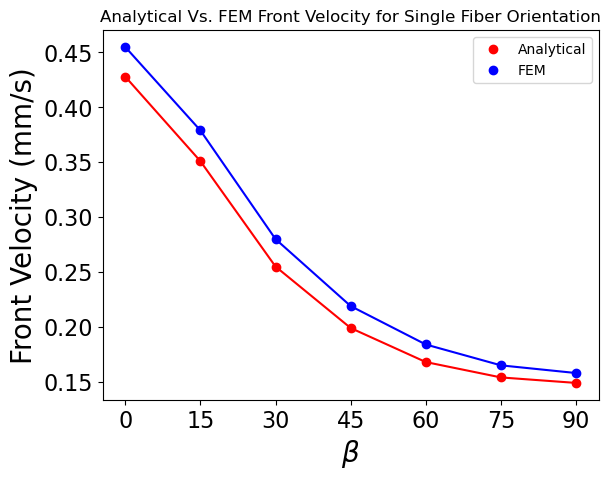

In [2]:
singles = ['0', '15', '30', '45', '60', '75', '90']
single_vs = np.array([Vs_corrected[i] for i in range(len(Vs)) if betas[i] in singles])
single_betas = np.array([betas[i] for i in range(len(Vs)) if betas[i] in singles])
single_vs_linear_fit = np.array([linear_fit_vs[i] for i in range(len(Vs)) if betas[i] in singles])

mask = np.argsort(single_betas)
plt.plot(single_betas[mask], single_vs[mask], 'o', label='Analytical', color = 'r')
plt.plot(single_betas[mask], single_vs[mask], color = 'r')

plt.plot(single_betas[mask], single_vs_linear_fit[mask], 'o', label='FEM', color = 'b')
plt.plot(single_betas[mask], single_vs_linear_fit[mask], color = 'b')

plt.xlabel(r'$\beta$', fontsize=20)
plt.ylabel('Front Velocity (mm/s)', fontsize=20)
plt.title('Analytical Vs. FEM Front Velocity for Single Fiber Orientation', fontsize = 12)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend()

plt.savefig('single_fiber_orientation.png', dpi=300, bbox_inches='tight')

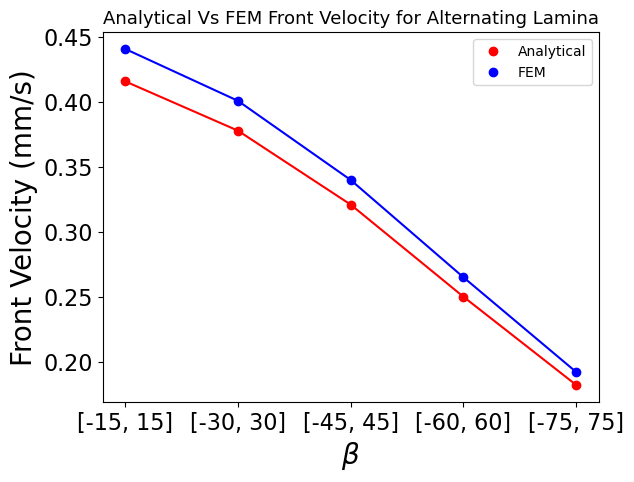

In [3]:
singles = ['0', '15', '30', '45', '60', '75', '90']
alternating_vs = np.array([Vs_corrected[i] for i in range(len(Vs)) if betas[i] not in singles])
alternating_betas = np.array([betas[i] for i in range(len(Vs)) if betas[i] not in singles])
alternating_vs_linear_fit = np.array([linear_fit_vs[i] for i in range(len(Vs)) if betas[i] not in singles])

mask = np.argsort(alternating_betas, axis = 0)
plt.plot(alternating_betas[mask], alternating_vs[mask], 'o', label='Analytical', color = 'r')
plt.plot(alternating_betas[mask], alternating_vs[mask], color = 'r')

plt.plot(alternating_betas[mask], alternating_vs_linear_fit[mask], 'o', label='FEM', color = 'b')
plt.plot(alternating_betas[mask], alternating_vs_linear_fit[mask], color = 'b')

plt.xlabel(r'$\beta$', fontsize = 20)
plt.ylabel('Front Velocity (mm/s)', fontsize = 20)
plt.title('Analytical Vs FEM Front Velocity for Alternating Lamina', fontsize = 13)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend()
plt.savefig('alternating_lamina.png', dpi=300, bbox_inches='tight')

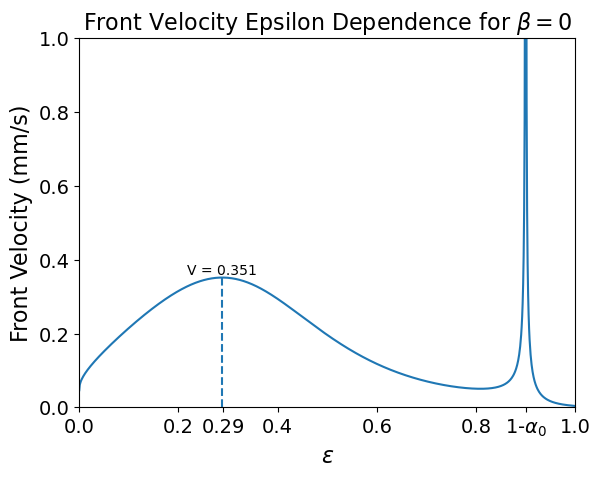

In [79]:
# Need to redefine pi to reduce max iterations here
pi = lambda eps: quadrature(pi_integrand, 0, 1-eps-a0, args=(m, n, Ca, ac, eps), maxiter = int(1e3))[0]
# Redefine V_f to plot epsilon dependence of velocity for beta = 0
V_f = lambda eps: -V_front(T_est(eps), pi(eps), Ar, A_0[0,0], R, Er, rhor, Hr, phi)

epsilons = np.linspace(0,1,1000)
velocities = []
for eps in epsilons:
  
    velocities.append(V_f(eps))

velocities = np.array(velocities)*-1000
plt.plot(epsilons, velocities)
ax = plt.gca()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.text(eps_max, Vs[0], f"V = {str(Vs[0])[:5]}", ha = 'center', va = 'bottom')
#ax.text(epsilons[np.argmax(velocities)], 0, f"V = {str(np.max(velocities))[:5]}", ha = 'center', va = 'bottom')

xticks = ax.get_xticks() 
xticks = np.append(np.round(xticks,2), eps_max)
xticks = np.append(np.round(xticks,2), epsilons[np.argmax(velocities)])

xticklabels=xticks.tolist()
xticklabels[-2]= str(np.round(eps_max, 2))
xticklabels[-1] = r'1-$\alpha_{0}$'
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

ax.vlines(eps_max, 0, Vs[0], ls='--')

ax.set_ylabel("Front Velocity (mm/s)", fontsize = 16)
ax.set_xlabel(r"$\epsilon$", fontsize = 16)
ax.set_title(r"Front Velocity Epsilon Dependence for $\beta = 0$", fontsize=16)
ax.tick_params(axis='both', labelsize=14)
plt.savefig("epsilon_dependence.png", dpi = 300, bbox_inches = 'tight')
plt.show()

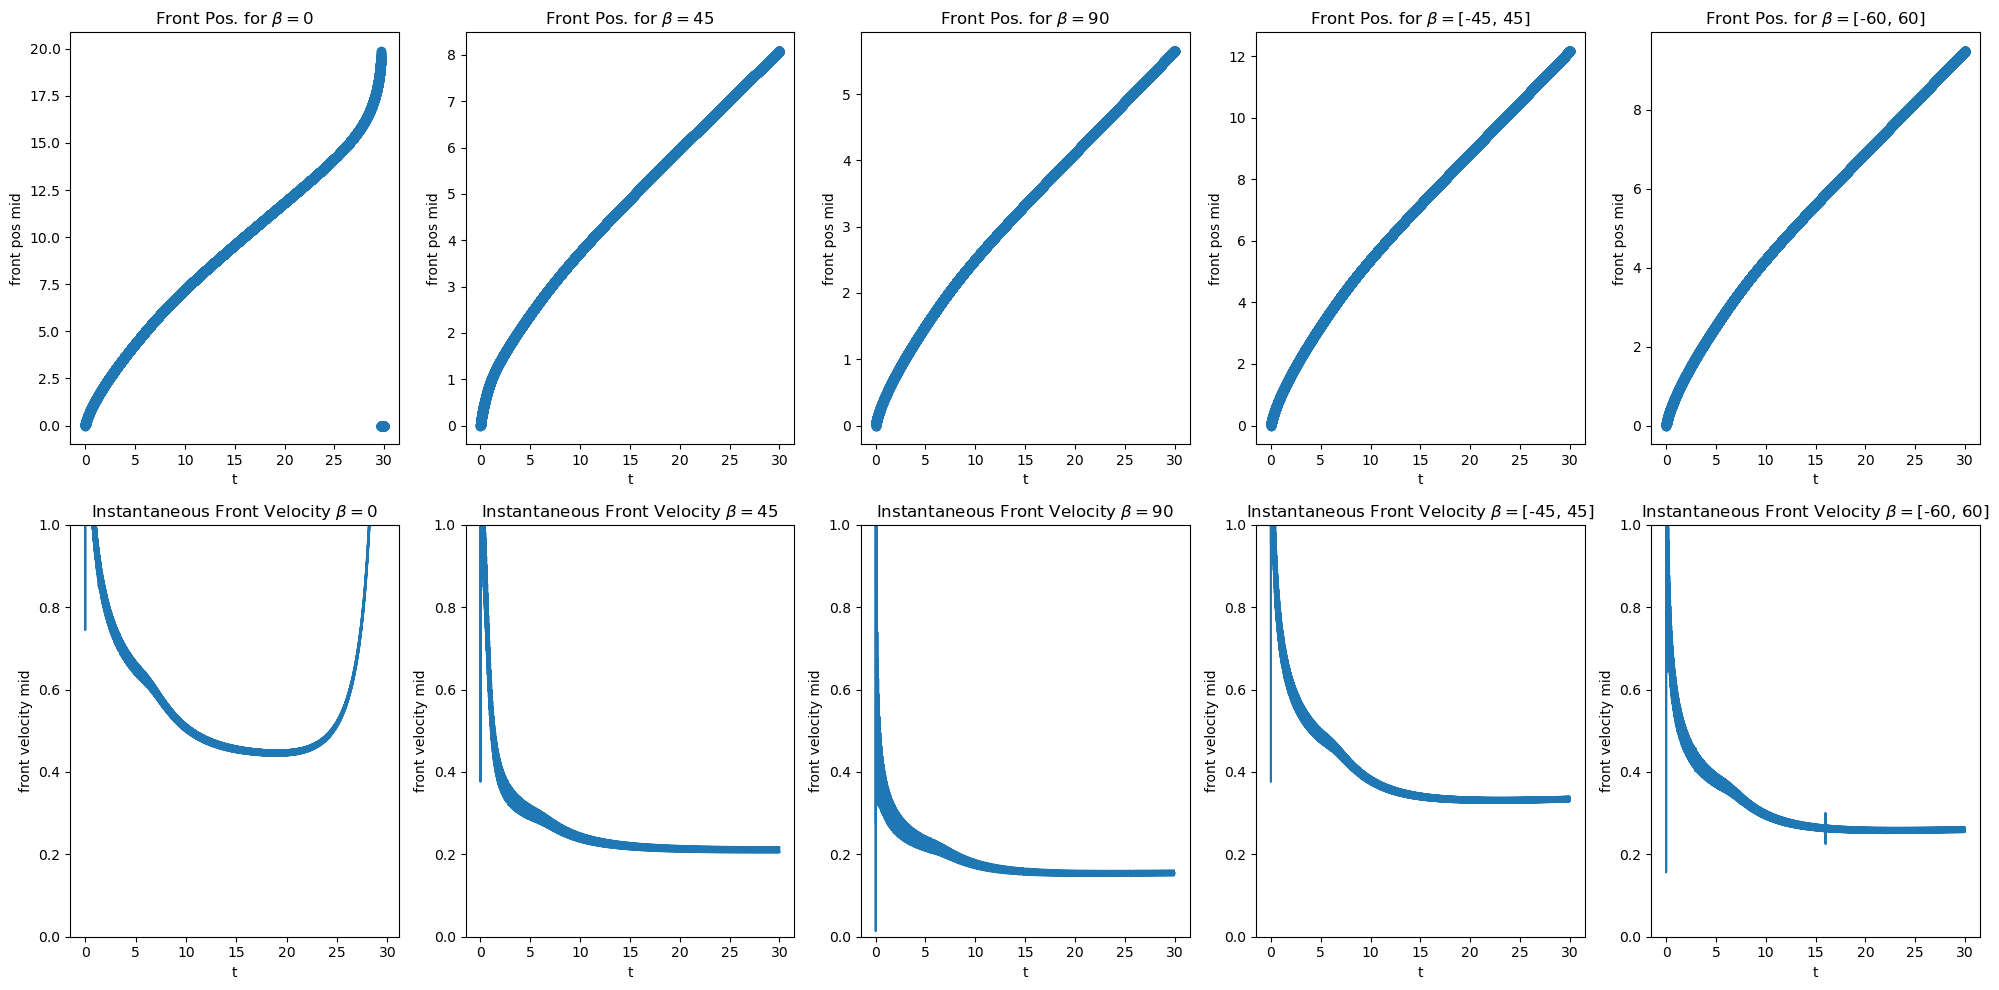

In [16]:
fig, axes = plt.subplots(nrows = 2, ncols = len(dfs))
for i in range(len(dfs)):

    df = dfs[i]
    t = df['t'].values
    x_bot = df['x_bot'].values
    x_top = df['x_top'].values
    x_mid = df['x_mid'].values
    alpha_bot = df['alpha_bot'].values
    alpha_mid = df['alpha_mid'].values
    alpha_top = df['alpha_top'].values

    axes[0][i].scatter(t, x_mid*1000)
    axes[0][i].set_xlabel("t")
    axes[0][i].set_ylabel("front pos mid")
    axes[0][i].set_title(r"Front Pos. for $\beta = $" + str(betas[i]))

    mask =  np.where(x_mid > 0)
    v = central_finite(x_mid[mask])
    axes[1][i].plot(t[mask], v*1000)
    axes[1][i].set_xlabel("t")
    axes[1][i].set_ylabel("front velocity mid")
    axes[1][i].set_title(r"Instantaneous Front Velocity $\beta=$" + str(betas[i]))
    axes[1][i].set_ylim(0,1)
    
fig.set_size_inches(20,10)
fig.tight_layout()
fig.savefig('tmp.png',dpi=200)

In [ ]:
# monitor system processes and kill any named corina
# processes that are running
def kill_corina():
    for proc in psutil.process_iter():
        if proc.name() == "corina":
            proc.kill()





In [ ]:
def tensor_product():
    # define the tensor product of two vectors
    # a and b are vectors of length 3
    # returns a 3x3 matrix
    a = np.array([1,2,3])
    b = np.array([4,5,6])
    return np.outer(a,b)